In [1]:
!gdown --id 1FxvmwTrYZsMyCMfH_mcrLJ2oStXABQG_

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1FxvmwTrYZsMyCMfH_mcrLJ2oStXABQG_
To: /content/dataset.zip
100% 1.26G/1.26G [00:04<00:00, 289MB/s]


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import zipfile

## Libraries

In [3]:
with zipfile.ZipFile("dataset.zip","r") as zip_ref:
    zip_ref.extractall("targetdir")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import tensorflow
import glob
import tqdm
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

%matplotlib inline

In [7]:
train_normal = glob.glob('/content/targetdir/chest_xray/train/NORMAL/*.jp*g')
len(train_normal)

1349

In [8]:
train_pneumonia = glob.glob('/content/targetdir/chest_xray/train/PNEUMONIA/*.jp*g')
len(train_pneumonia)

3883

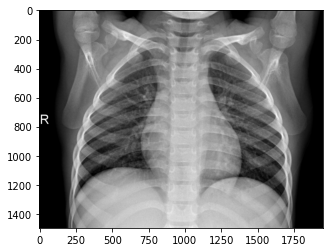

In [9]:
img = image.load_img(np.random.choice(train_normal))
plt.imshow(img)

In [11]:
# Total training images
x = len(train_normal)
y = len(train_pneumonia)
print("Total number of training images are: " , x + y)

Total number of training images are:  5232


In [12]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.0,
                                   zoom_range = 0.4,
                                   validation_split = 0.80)

valid_datagen = ImageDataGenerator(rescale = 1.0 / 255.0, validation_split = 0.9)

test_datagen  = ImageDataGenerator(rescale = 1.0 / 255.0)

In [13]:
train_dataset = train_datagen.flow_from_directory(directory = '/content/targetdir/chest_xray/train',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  subset = 'training',
                                                  batch_size = 64)

Found 1047 images belonging to 2 classes.


In [14]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/targetdir/chest_xray/train',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 4708 images belonging to 2 classes.


In [15]:
# Checking Indices
train_dataset.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
len(train_dataset)

17

100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


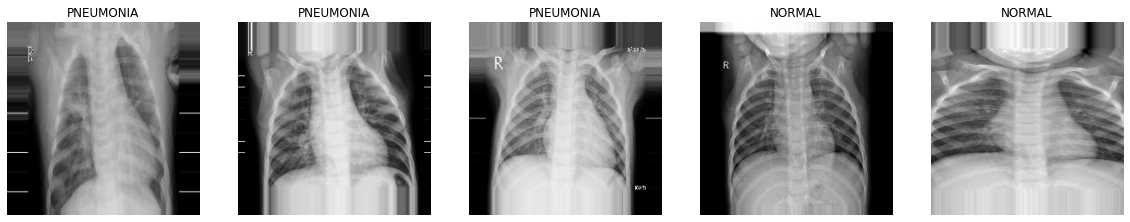

In [17]:
# Viewing Images 
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(64)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    label = train_dataset[rand1][1][rand2]
    if label == 1:
        ax[i].set_title('PNEUMONIA')
    else:
        ax[i].set_title('NORMAL')

In [21]:
# Defining Model
vgg = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [23]:
# Freezing Layers 
for layer in vgg.layers:
    layer.trainable=False

In [24]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
_# Defining Layers
model=Sequential()
model.add(vgg)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [27]:
# Model Compile 
model.compile(loss='binary_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=tensorflow.keras.optimizers.Adam(lr=0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
# Model Fitting 
model.fit(train_dataset,
          validation_data=valid_dataset,
          epochs = 10,
          verbose = 1)

Epoch 1/10
17/17 [==============================] - 73s 5s/step - loss: 0.2069 - auc: 0.9724 - val_loss: 0.1448 - val_auc: 0.9831
Epoch 2/10
17/17 [==============================] - 73s 4s/step - loss: 0.1554 - auc: 0.9782 - val_loss: 0.1204 - val_auc: 0.9912
Epoch 3/10
17/17 [==============================] - 72s 4s/step - loss: 0.1777 - auc: 0.9743 - val_loss: 0.1361 - val_auc: 0.9890
Epoch 4/10
17/17 [==============================] - 72s 4s/step - loss: 0.1551 - auc: 0.9798 - val_loss: 0.1447 - val_auc: 0.9870
Epoch 5/10
17/17 [==============================] - 71s 4s/step - loss: 0.1445 - auc: 0.9843 - val_loss: 0.1553 - val_auc: 0.9892
Epoch 6/10
17/17 [==============================] - 71s 4s/step - loss: 0.1349 - auc: 0.9848 - val_loss: 0.1339 - val_auc: 0.9897
Epoch 7/10
17/17 [==============================] - 72s 4s/step - loss: 0.1387 - auc: 0.9831 - val_loss: 0.1177 - val_auc: 0.9909
Epoch 8/10
17/17 [==============================] - 71s 4s/step - loss: 0.1164 - auc: 0.98

In [32]:
# Test Data 

test_dataset = test_datagen.flow_from_directory(directory = '/content/targetdir/chest_xray/test',
                                                target_size = (224,224),
                                                class_mode = 'binary',
                                                batch_size = 64)

Found 624 images belonging to 2 classes.


In [27]:
# Evaluating Loss and AUC - Test Data 
model.evaluate(test_dataset)

10/10 [==============================] - 11s 1s/step - loss: 0.2784 - auc: 0.9600


[0.2783735692501068, 0.9599714875221252]

The X-RAY belongs to NORMAL person


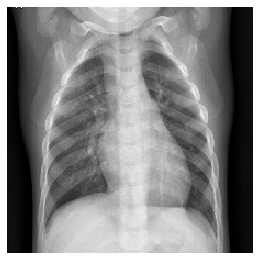

In [33]:
# Test Case 1: NORMAL

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/targetdir/chest_xray/test/NORMAL/NORMAL-1212407-0001.jpeg', target_size=(224,224))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The X-Ray belongs to PNEUMONIA person")
else:
    print("The X-RAY belongs to NORMAL person")


The X-Ray belongs to PNEUMONIA person


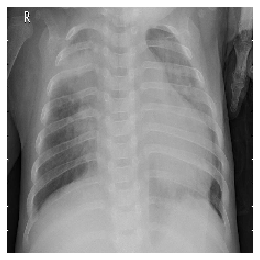

In [34]:
# Test Case 2: PNEUMONIA

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/targetdir/chest_xray/test/PNEUMONIA/BACTERIA-1220485-0001.jpeg', target_size=(224,224))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)

if answer[0][0] > 0.5:
    print("The X-Ray belongs to PNEUMONIA person")
else:
    print("The X-RAY belongs to NORMAL person")